In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import math
from PIL import Image

In [2]:
content = Image.open('images/owl_on_branch.jpg')
style = Image.open('images/african_art_2.jpg')

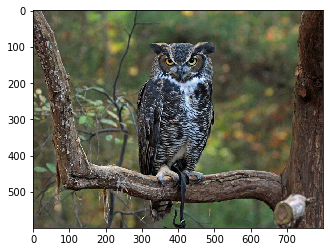

In [3]:
# Just show the content image
plt.imshow(content)
plt.show()

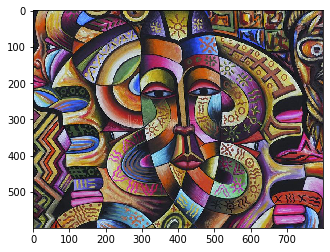

In [4]:
# Just show the style image
plt.imshow(style)
plt.show()

In [5]:
# Convert the images to numpy arrays
content_array = np.asarray(content)
style_array = np.asarray(style)
assert content_array.shape == style_array.shape

# Get the HEIGHT and WIDTH in case it is needed later
SHAPE = content_array.shape


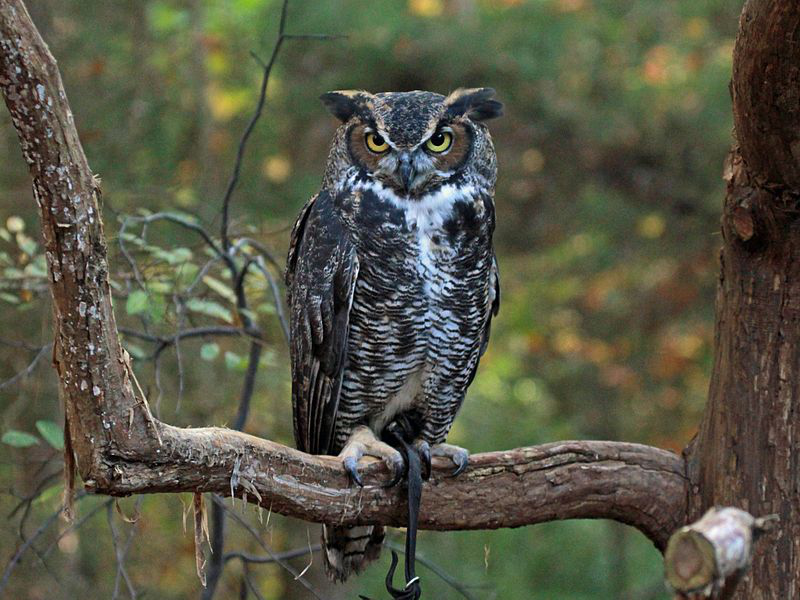

In [6]:
# Add noise to the content image to generate what the output should be
# gauss_noise = np.random.normal(0, 255, content_array.shape).astype('uint8')
# gauss_noise = gauss_noise * np.random.normal(0, 1, content_array.shape).astype('uint8')
# gen_img = np.add(content_array, gauss_noise)
# Image.fromarray(gen_img)
gen_img = content_array
Image.fromarray(gen_img)


In [7]:
vgg = tf.keras.applications.VGG19(include_top = False, weights = "imagenet", pooling = "avg", input_shape = SHAPE)
vgg.trainable = False

In [8]:
# Layers to use when computing the cost
CONTENT_LAYERS = [
    ('block4_conv2', 0.2),
]

STYLE_LAYERS = [
    ('block1_conv2', 0.2),
    ('block2_conv2', 0.2),
    ('block3_conv2', 0.2),
    ('block4_conv2', 0.2),
    ('block5_conv2', 0.2)
]

In [9]:
def normalize_data(image):
    return tf.keras.applications.vgg19.preprocess_input(image)

In [ ]:
# Only need to run this if you want to test VGG19

# Full VGG19 to make sure it is working
vgg_test = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg_test(tf.image.resize(norm_content, (224, 224)))
prediction_probabilities.shape

predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

In [11]:
# Create a model for the style and the content using VGG
def vgg_model_output(layers):
    layer_outputs = []
    for layer, weight in layers:
        layer_outputs.append(vgg.get_layer(layer).output)
    return tf.keras.Model([vgg.input], layer_outputs)



In [12]:
norm_content = normalize_data(content_array).reshape(1, SHAPE[0], SHAPE[1], SHAPE[2])
norm_style = normalize_data(style_array).reshape(1, SHAPE[0], SHAPE[1], SHAPE[2])
norm_gen_img = normalize_data(gen_img).reshape(1, SHAPE[0], SHAPE[1], SHAPE[2])

a_gen_content_layers = vgg_model_output(CONTENT_LAYERS)(norm_gen_img)
a_gen_style_layers = vgg_model_output(STYLE_LAYERS)(norm_gen_img)
a_content_layers = vgg_model_output(CONTENT_LAYERS)(norm_content)
a_style_layers = vgg_model_output(STYLE_LAYERS)(norm_style)


In [13]:
# Compute the cost of the content given the activations
def compute_content_cost(a_gen_img, a_content_img):
    total_cost = 0
    for layer in range(0, len(a_gen_img)):
        # Get the output layer
        a_G_layer =  a_gen_img[layer]
        a_C_layer = a_content_img[layer]
        
        # Get the dimensions
        n_H, n_W, n_C = a_G_layer.get_shape().as_list()
        
        # Unroll the activations
        unrolled_aG = tf.reshape(a_G_layer, [1, n_W * n_H, n_C])
        unrolled_aC = tf.reshape(a_C_layer, [1, n_W * n_H, n_C])
        
        # Compute the cots and add it to total_cost
        total_cost += (1/(4 * n_W * n_H * n_C)) * tf.math.reduce_sum(tf.math.square(tf.subtract(unrolled_aG, unrolled_aC)))
    
    return total_cost



In [14]:
# Compute the gram matrix
# Want to have the gram matrix in shape n_C by n_C
# Input matrix should be n_C x (n_W * n_H)
def compute_gram(matrix):
    return tf.linalg.matmul(matrix, tf.transpose(matrix))


In [15]:
# Compute style cost on a layer
def style_cost_layer(a_gen_layer, a_style_layer, n_C, n_W, n_H):
    G_a_gen_layer = compute_gram(a_gen_layer)
    G_a_style_layer = compute_gram(a_style_layer)
    return (1/(4 * math.pow(n_C, 2) * math.pow(n_W * n_H, 2))) * tf.reduce_sum(tf.math.square(tf.math.subtract(G_a_gen_layer, G_a_style_layer)))

In [16]:
# Compute style cost on all of the out layers from the VGG19 model
def total_style_cost(a_gen_style_layers, a_style_layers):
    total_cost = 0.0
    for layer in range(0, len(a_gen_style_layers)):
        a_gen_style_layer = a_gen_style_layers[layer]
        a_style_layer = a_style_layers[layer]
        m, n_H, n_W, n_C = a_gen_style_layer.get_shape().as_list()
        a_gen_style_layer = tf.reshape(tf.transpose(a_gen_style_layer, perm=[3, 1, 2, 0]), shape=[n_C, n_W * n_H])
        a_style_layer = tf.reshape(tf.transpose(a_style_layer, perm=[3, 1, 2, 0]), shape=[n_C, n_W * n_H])
        total_cost = total_cost + STYLE_LAYERS[layer][1] * style_cost_layer(a_gen_style_layer, a_style_layer, n_C, n_W, n_H)
    return total_cost


In [17]:
total_style_cost(a_gen_style_layers, a_style_layers)

<tf.Tensor: shape=(), dtype=float32, numpy=3313215000.0>

In [18]:
# Compute the total cost
def total_cost(content_cost, style_cost, alpha = 10, beta = 40):
    total_cost = (alpha * content_cost) + (beta * style_cost)
    return total_cost


In [19]:
def gen_new_outputs(gen_img):
    print(type(gen_img))
    a_gen_content_layers = vgg_model_output(CONTENT_LAYERS)(normalize_data(gen_img))
    a_gen_style_layers = vgg_model_output(STYLE_LAYERS)(normalize_data(gen_img))
    return a_gen_content_layers, a_gen_style_layers


In [20]:
# Define the optimizer
opt = tf.optimizers.Adam(learning_rate = 0.02, beta_1=0.99, epsilon=1e-1)
print(type(gen_img))
gen_img = tf.reshape(gen_img, [1, SHAPE[0], SHAPE[1], SHAPE[2]])
gen_img = tf.Variable(tf.cast(gen_img, tf.float32))
print(gen_img.shape)

<class 'numpy.ndarray'>
(1, 600, 800, 3)


In [21]:

def train_step(gen_img):
    with tf.GradientTape() as tape:
        a_gen_content_layers, a_gen_style_layers = gen_new_outputs(gen_img)
        content_cost = compute_content_cost(a_gen_content_layers, a_content_layers)
        style_cost = total_style_cost(a_gen_style_layers, a_style_layers)
        loss = total_cost(content_cost, style_cost)

    grad = tape.gradient(loss, gen_img)
    opt.apply_gradients([(grad, gen_img)])


0 0
uint8


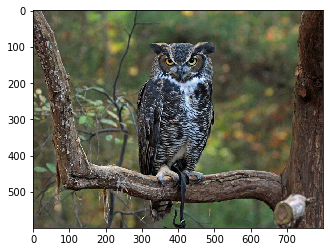

<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
0 1
<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
0 2
<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
0 3
<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
0 4
<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
0 5
<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
0 6
<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
0 7
<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
0 8
<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
0 9
<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
0 10
uint8


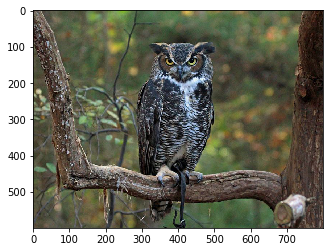

<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
0 11
<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
0 12
<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
0 13
<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
0 14
<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
0 15
<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
0 16
<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
0 17
<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
0 18
<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
0 19
<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
0 20
uint8


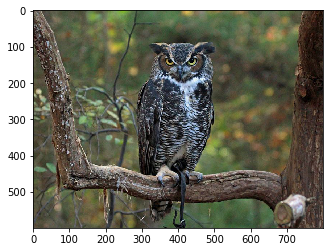

<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
0 21
<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
0 22
<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
0 23
<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
0 24
<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
0 25
<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
0 26
<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
0 27
<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
0 28
<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
0 29
<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
0 30
uint8


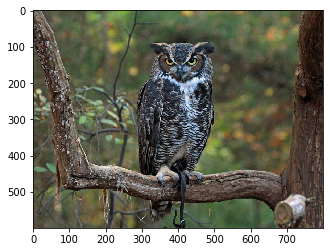

<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
0 31
<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
0 32
<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
0 33
<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
0 34
<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
0 35
<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
0 36
<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
0 37
<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
0 38
<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
0 39
<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
0 40
uint8


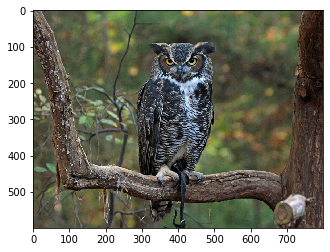

<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
0 41
<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
0 42
<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>


KeyboardInterrupt: 

In [22]:
for x in range(10):
    for y in range(100):
        print(x, y)
        if y % 10 == 0:
            arr = gen_img.numpy()
            arr.shape
            arr = arr.astype(np.uint8)
            print(arr.dtype)
            arr = arr.reshape(SHAPE[0], SHAPE[1], SHAPE[2])
            plt.imshow(Image.fromarray(arr))
            plt.show()
        train_step(gen_img)

In [ ]:
arr = gen_img.numpy()
arr.shape
arr = arr.astype(np.uint8)
print(arr.dtype)
arr = arr.reshape(SHAPE[0], SHAPE[1], SHAPE[2])
Image.fromarray(arr)